In [1]:
from __future__ import print_function, absolute_import
import argparse
import os.path as osp
import random
import numpy as np
import sys
from itertools import islice
from collections import OrderedDict

from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import normalize

import torch
from torch import nn
from torch.backends import cudnn
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from torch.nn import init
#
# from UDAsbs.utils.rerank import compute_jaccard_dist

from UDAsbs import datasets, sinkhornknopp as sk
from UDAsbs import models
from UDAsbs.trainers import DbscanBaseTrainer_unc_ema, DbscanBaseTrainer_unc_ema_single
from UDAsbs.evaluators import Evaluator, extract_features
from UDAsbs.utils.data import IterLoader
from UDAsbs.utils.data import transforms as T
from UDAsbs.utils.data.sampler import RandomMultipleGallerySampler
from UDAsbs.utils.data.preprocessor import Preprocessor
from UDAsbs.utils.logging import Logger
from UDAsbs.utils.serialization import load_checkpoint, save_checkpoint#, copy_state_dict

from UDAsbs.memorybank.NCEAverage import onlinememory
from UDAsbs.utils.faiss_rerank import compute_jaccard_distance
# import ipdb

parser = argparse.ArgumentParser(description="MMT Training")
# data
parser.add_argument('-st', '--dataset-source', type=str, default='market1501',
                    choices=datasets.names())
parser.add_argument('-tt', '--dataset-target', type=str, default='dukemtmc',
                    choices=datasets.names())
parser.add_argument('-b', '--batch-size', type=int, default=32)
parser.add_argument('-j', '--workers', type=int, default=8)
parser.add_argument('--choice_c', type=int, default=0)
parser.add_argument('--num-clusters', type=int, default=700)
parser.add_argument('--ncs', type=str, default='60')

parser.add_argument('--k1', type=int, default=30,
                    help="hyperparameter for jaccard distance")
parser.add_argument('--k2', type=int, default=6,
                    help="hyperparameter for jaccard distance")

parser.add_argument('--height', type=int, default=224,
                    help="input height")
parser.add_argument('--width', type=int, default=224,
                    help="input width")

parser.add_argument('--num-instances', type=int, default=4,
                    help="each minibatch consist of "
                            "(batch_size // num_instances) identities, and "
                            "each identity has num_instances instances, "
                            "default: 0 (NOT USE)")
# model
parser.add_argument('-a', '--arch', type=str, default='Swin',
                    choices=models.names())
parser.add_argument('--features', type=int, default=0)
parser.add_argument('--dropout', type=float, default=0)
# optimizer

parser.add_argument('--lr', type=float, default=0.00035,
                    help="learning rate of new parameters, for pretrained "
                            "parameters it is 10 times smaller than this")
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--schedule_step', type=int, default=10)
parser.add_argument('--alpha', type=float, default=0.999)
parser.add_argument('--moving-avg-momentum', type=float, default=0)
parser.add_argument('--weight-decay', type=float, default=5e-4)
parser.add_argument('--soft-ce-weight', type=float, default=0.5)
parser.add_argument('--soft-tri-weight', type=float, default=0.8)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--iters', type=int, default=200)

parser.add_argument('--lambda-value', type=float, default=0)
# training configs

parser.add_argument('--rr-gpu', action='store_true',
                    help="use GPU for accelerating clustering")
# parser.add_argument('--init-1', type=str, default='logs/personxTOpersonxval/resnet_ibn50a-pretrain-1_gem_RA//model_best.pth.tar', metavar='PATH')
parser.add_argument('--init_1', type=str,
                    default='/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model1_checkpoint.pth.tar',
                    metavar='PATH')
parser.add_argument('--init_2', type=str,
                    default='/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model2_checkpoint.pth.tar',
                    metavar='PATH')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--print-freq', type=int, default=100)
parser.add_argument('--eval-step', type=int, default=5)
parser.add_argument('--n-jobs', type=int, default=16)
# path
working_dir = osp.dirname(osp.abspath(''))
parser.add_argument('--data-dir', type=str, metavar='PATH',
                    default=osp.join(working_dir, '/home/jun/ReID_Dataset'))
parser.add_argument('--logs-dir', type=str, metavar='PATH',
                    default='logs/evalute_market1501TOdukemtmc/Swin_uncertainly')

parser.add_argument('--lambda-tri', type=float, default=1.0)
parser.add_argument('--lambda-reg', type=float, default=1.0)
parser.add_argument('--lambda-ct', type=float, default=0.05)
parser.add_argument('--uncer-mode', type=float, default=0)#0 mean 1 max 2 min

print("======mmt_train_dbscan_self-labeling=======")
args = parser.parse_args('')


start_epoch = best_mAP = 0

def get_data(name, data_dir, l=1):
    root = osp.join(data_dir)

    dataset = datasets.create(name, root, l)

    label_dict = {}
    for i, item_l in enumerate(dataset.train):
        # dataset.train[i]=(item_l[0],0,item_l[2])
        if item_l[1] in label_dict:
            label_dict[item_l[1]].append(i)
        else:
            label_dict[item_l[1]] = [i]

    return dataset, label_dict



def get_test_loader(dataset, height, width, batch_size, workers, testset=None):
    normalizer = T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    test_transformer = T.Compose([
        T.Resize((height, width), interpolation=3),
        T.ToTensor(),
        normalizer
    ])

    if (testset is None):
        testset = list(set(dataset.query) | set(dataset.gallery))

    test_loader = DataLoader(
        Preprocessor(testset, root=dataset.images_dir, transform=test_transformer),
        batch_size=batch_size, num_workers=workers,
        shuffle=False, pin_memory=True)

    return test_loader

from UDAsbs.models.dsbn import convert_dsbn
from torch.nn import Parameter


def copy_state_dict(state_dict, model, strip=None):
    tgt_state = model.state_dict()
    copied_names = set()
    for name, param in state_dict.items():
        name = name.replace('module.', '')
        if strip is not None and name.startswith(strip):
            name = name[len(strip):]
        if name not in tgt_state:
            continue
        if isinstance(param, Parameter):
            param = param.data
        if param.size() != tgt_state[name].size():
            print('mismatch:', name, param.size(), tgt_state[name].size())
            continue
        tgt_state[name].copy_(param)
        copied_names.add(name)

    missing = set(tgt_state.keys()) - copied_names
    if len(missing) > 0:
        print("missing keys in state_dict:", missing)

    return model

def create_model(args, mb_h, ncs, wopre=False):
    model_1 = models.create(args.arch, mb_h = mb_h, num_features=args.features, dropout=args.dropout,
                            num_classes=ncs)
    if not wopre:

        initial_weights = load_checkpoint(args.init_1)
        copy_state_dict(initial_weights['state_dict'], model_1)
        print('load pretrain model:{}'.format(args.init_1))

    # adopt domain-specific BN
    convert_dsbn(model_1)
    model_1.cuda()
    model_1 = nn.DataParallel(model_1)

    return model_1


class Optimizer:
    def __init__(self, target_label, m, dis_gt, t_loader,N, hc=3, ncl=None,  n_epochs=200,
                 weight_decay=1e-5, ckpt_dir='/',fc_len=3500):
        self.num_epochs = n_epochs
        self.momentum = 0.9
        self.weight_decay = weight_decay
        self.checkpoint_dir = ckpt_dir
        self.N=N
        self.resume = True
        self.checkpoint_dir = None
        self.writer = None
        # model stuff
        self.hc = len(ncl)#10
        self.K = ncl#3000
        self.K_c =[fc_len for _ in range(len(ncl))]
        self.model = m
        self.dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.L = [torch.LongTensor(target_label[i]).to(self.dev) for i in range(len(self.K))]
        self.nmodel_gpus = 4#len()
        self.pseudo_loader = t_loader#torch.utils.data.DataLoader(t_loader,batch_size=256)
        # can also be DataLoader with less aug.
        self.train_loader = t_loader
        self.lamb = 25#args.lamb # the parameter lambda in the SK algorithm
        self.cpu=True
        self.dis_gt=dis_gt
        dtype_='f64'
        if dtype_ == 'f32':
            self.dtype = torch.float32 if not self.cpu else np.float32
        else:
            self.dtype = torch.float64 if not self.cpu else np.float64

        self.outs = self.K
        # activations of previous to last layer to be saved if using multiple heads.
        self.presize =  2048#4096 #

    def optimize_labels(self):
        if self.cpu:
            sk.cpu_sk(self)
        else:
            sk.gpu_sk(self)

        # save Label-assignments: optional
        # torch.save(self.L, os.path.join(self.checkpoint_dir, 'L', str(niter) + '_L.gz'))

        # free memory
        data = 0
        self.PS = 0

        return self.L

import collections


def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def write_sta_im(train_loader):
    label2num=collections.defaultdict(int)
    save_label=[]
    for x in train_loader:
        label2num[x[1]]+=1
        save_label.append(x[1])
    labels=sorted(label2num.items(),key=lambda item:item[1])[::-1]
    num = [j for i, j in labels]
    distribution = np.array(num)/len(train_loader)

    return num,save_label
def print_cluster_acc(label_dict,target_label_tmp):
    num_correct = 0
    for pid in label_dict:
        pid_index = np.asarray(label_dict[pid])
        pred_label = np.argmax(np.bincount(target_label_tmp[pid_index]))
        num_correct += (target_label_tmp[pid_index] == pred_label).astype(np.float32).sum()
    cluster_accuracy = num_correct / len(target_label_tmp)
    print(f'cluster accucary: {cluster_accuracy:.3f}')


class uncer(object):
    def __init__(self):
        self.sm = torch.nn.Softmax(dim=1)
        self.log_sm = torch.nn.LogSoftmax(dim=1)
        # self.cross_batch=CrossBatchMemory()
        self.kl_distance = nn.KLDivLoss(reduction='none')
    def kl_cal(self,pred1,pred1_ema):
        variance = torch.sum(self.kl_distance(self.log_sm(pred1),
                                              self.sm(pred1_ema.detach())), dim=1)
        exp_variance = torch.exp(-variance)
        return exp_variance

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


2.3.0
======mmt_train_dbscan_self-labeling=======


In [2]:

cudnn.benchmark = True

sys.stdout = Logger(osp.join(args.logs_dir, 'log.txt'))
print("==========\nArgs:{}\n==========".format(args))

# Create data loaders
iters = args.iters if (args.iters > 0) else None
ncs = [int(x) for x in args.ncs.split(',')]
# ncs_dbscan=ncs.copy()
dataset_target, label_dict = get_data(args.dataset_target, args.data_dir, len(ncs))
test_loader_target = get_test_loader(dataset_target, args.height, args.width, args.batch_size, args.workers)

if args.arch in ['hrnet', 'ResNet50', 'resnet50_sbs', 'ResNet50_multi', 'resnet50_multi', 'resnet50_multi_sbs']: 
    mb_h = 2048
elif args.arch == 'ViT':
    mb_h = 768
elif args.arch == 'Swin':
    mb_h = 1024
else:
    pass
fc_len = 3500
model_1 = create_model(args, mb_h, [fc_len for _ in range(len(ncs))])



Args:Namespace(dataset_source='market1501', dataset_target='dukemtmc', batch_size=32, workers=8, choice_c=0, num_clusters=700, ncs='60', k1=30, k2=6, height=224, width=224, num_instances=4, arch='Swin', features=0, dropout=0, lr=0.00035, momentum=0.9, schedule_step=10, alpha=0.999, moving_avg_momentum=0, weight_decay=0.0005, soft_ce_weight=0.5, soft_tri_weight=0.8, epochs=200, iters=200, lambda_value=0, rr_gpu=False, init_1='/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model1_checkpoint.pth.tar', init_2='/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model2_checkpoint.pth.tar', seed=1, print_freq=100, eval_step=5, n_jobs=16, data_dir='/home/jun/ReID_Dataset', logs_dir='logs/evalute_market1501TOdukemtmc/Swin_uncertainly', lambda_tri=1.0, lambda_reg=1.0, lambda_ct=0.05, uncer_mode=0)
This dataset has been downloaded.
=> DukeMTMC-reID loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | #

GeneralizedMeanPoolingP
=> Loaded checkpoint '/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model1_checkpoint.pth.tar'
mismatch: classifier0_3500.weight torch.Size([1498, 1024]) torch.Size([3500, 1024])
missing keys in state_dict: {'mbn.bias', 'feat_bn.running_mean', 'mbn.weight', 'feat_bn.num_batches_tracked', 'mbn.running_var', 'feat_bn.bias', 'feat_bn.weight', 'classifier0_3500.weight', 'mbn.running_mean', 'feat_bn.running_var', 'mbn.num_batches_tracked'}
load pretrain model:/home/jun/UDAStrongBaseline/logs/dbscan-market1501TOdukemtmc/Swin_uncertainly/model1_checkpoint.pth.tar


In [3]:
features, labels = extract_features(model_1, test_loader_target)
#query_features, query_labels = extract_features(model_1, query_loader, choice_c=0, print_freq=100)
#gallery_features, gallery_labels = extract_features(model_1, gallery_loader, choice_c=0, print_freq=100)

Extract Features: [100/622]	Time 0.104 (0.089)	Data 0.000 (0.003)	
Extract Features: [200/622]	Time 0.103 (0.089)	Data 0.000 (0.002)	
Extract Features: [300/622]	Time 0.050 (0.089)	Data 0.000 (0.001)	
Extract Features: [400/622]	Time 0.104 (0.089)	Data 0.000 (0.001)	
Extract Features: [500/622]	Time 0.103 (0.089)	Data 0.000 (0.001)	
Extract Features: [600/622]	Time 0.103 (0.089)	Data 0.000 (0.001)	
Query Image 1: /home/jun/ReID_Dataset/./DukeMTMC-reID/query/0207_c2_f0094011.jpg
Query Image 1: /home/jun/ReID_Dataset/./DukeMTMC-reID/query/0207_c2_f0094011.jpg
Top 1 Gallery Image: /home/jun/ReID_Dataset/./DukeMTMC-reID/bounding_box_test/0207_c1_f0090574.jpg
Top 2 Gallery Image: /home/jun/ReID_Dataset/./DukeMTMC-reID/bounding_box_test/0207_c1_f0090454.jpg
Top 3 Gallery Image: /home/jun/ReID_Dataset/./DukeMTMC-reID/bounding_box_test/0207_c6_f0078501.jpg
Top 4 Gallery Image: /home/jun/ReID_Dataset/./DukeMTMC-reID/bounding_box_test/0207_c5_f0099608.jpg
Top 5 Gallery Image: /home/jun/ReID_Data

In [4]:
def pairwise_distance(features, query=None, gallery=None, metric=None):
    if query is None and gallery is None:
        n = len(features)
        x = torch.cat(list(features.values()))
        x = x.view(n, -1)
        if metric is not None:
            x = metric.transform(x)
        dist_m = torch.pow(x, 2).sum(dim=1, keepdim=True) * 2
        dist_m = dist_m.expand(n, n) - 2 * torch.mm(x, x.t())
        return dist_m

    x = torch.cat([features[item[0]].unsqueeze(0) for item in query], 0)
    y = torch.cat([features[item[0]].unsqueeze(0) for item in gallery], 0)
    m, n = x.size(0), y.size(0)
    x = x.view(m, -1)
    y = y.view(n, -1)
    if metric is not None:
        x = metric.transform(x)
        y = metric.transform(y)
    dist_m = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(m, n) + \
           torch.pow(y, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    dist_m.addmm_(1, -2, x, y.t())
    return dist_m, x.numpy(), y.numpy()

distmat, query_features, gallery_features = pairwise_distance(features, dataset_target.query, dataset_target.gallery, metric=None)
query_ids = [item[1] for item in dataset_target.query]
gallery_ids = [item[1] for item in dataset_target.gallery]
query_cams = [item[-1] for item in dataset_target.query]
gallery_cams = [item[-1] for item in dataset_target.gallery]

In [5]:
from sklearn.metrics import average_precision_score

def to_numpy(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    return tensor.cpu().numpy()

def _unique_sample(ids_dict, num):
    mask = np.zeros(num, dtype=bool)
    for _, indices in ids_dict.items():
        i = np.random.choice(indices)
        mask[i] = True
    return mask


def mean_ap(distmat, query_ids=None, gallery_ids=None,
            query_cams=None, gallery_cams=None):
    distmat = to_numpy(distmat)
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute AP for each query
    aps = []
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        y_true = matches[i, valid]
        y_score = -distmat[i][indices[i]][valid]
        if not np.any(y_true): continue
        aps.append(average_precision_score(y_true, y_score))
    if len(aps) == 0:
        raise RuntimeError("No valid query")
    return np.mean(aps)

def cmc(distmat, query_ids=None, gallery_ids=None,
        query_cams=None, gallery_cams=None, topk=100,
        separate_camera_set=False,
        single_gallery_shot=False,
        first_match_break=False):
    distmat = to_numpy(distmat)
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute CMC for each query
    ret = np.zeros(topk)
    num_valid_queries = 0
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        if separate_camera_set:
            # Filter out samples from same camera
            valid &= (gallery_cams[indices[i]] != query_cams[i])
        if not np.any(matches[i, valid]): continue
        if single_gallery_shot:
            repeat = 10
            gids = gallery_ids[indices[i][valid]]
            inds = np.where(valid)[0]
            ids_dict = defaultdict(list)
            for j, x in zip(inds, gids):
                ids_dict[x].append(j)
        else:
            repeat = 1
        for _ in range(repeat):
            if single_gallery_shot:
                # Randomly choose one instance for each id
                sampled = (valid & _unique_sample(ids_dict, len(valid)))
                index = np.nonzero(matches[i, sampled])[0]
            else:
                index = np.nonzero(matches[i, valid])[0]
            delta = 1. / (len(index) * repeat)
            for j, k in enumerate(index):
                if k - j >= topk: break
                if first_match_break:
                    ret[k - j] += 1
                    break
                ret[k - j] += delta
        num_valid_queries += 1
    if num_valid_queries == 0:
        raise RuntimeError("No valid query")
    return ret.cumsum() / num_valid_queries

def calculate_rank_accuracy(distmat, query_ids, gallery_ids, query_cams=None, gallery_cams=None, topk=(1, 5, 10)):
    distmat = to_numpy(distmat)
    m, n = distmat.shape
    
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
        
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    
    ret = np.zeros(len(topk))
    num_valid_queries = 0
    
    for i in range(m):
        valid = ((gallery_ids[indices[i]] != query_ids[i]) | (gallery_cams[indices[i]] != query_cams[i]))
        index = np.nonzero(matches[i, valid])[0]
        if len(index) == 0: 
            continue
        num_valid_queries += 1
        
        for j, k in enumerate(topk):
            if len(index) < k:
                continue
            if index[0] < k:
                ret[j] += 1
    
    if num_valid_queries == 0:
        raise RuntimeError("No valid query")
    
    return ret / num_valid_queries


In [6]:
mAP = mean_ap(distmat, query_ids, gallery_ids, query_cams, gallery_cams)
rank_accuracies = calculate_rank_accuracy(distmat, query_ids, gallery_ids, query_cams, gallery_cams, topk=(1, 5, 10))

In [7]:
'Mean AP: {:4.1%}'.format(mAP)

'Mean AP: 69.8%'

In [8]:
f"Rank-1 accuracy:", rank_accuracies[0]

('Rank-1 accuracy:', 0.8339317773788151)

In [9]:
f"Rank-5 accuracy:", rank_accuracies[1]

('Rank-5 accuracy:', 0.8720825852782765)

In [10]:
f"Rank-10 accuracy:", rank_accuracies[2]

('Rank-10 accuracy:', 0.6669658886894075)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def rank_gallery_images(distmat):
    # Sort distances for each query
    indices = np.argsort(distmat, axis=1)
    return indices
ranked_indices = rank_gallery_images(distmat)

In [12]:
ranked_indices.shape

torch.Size([2228, 17661])

In [13]:
query_images = [img_path for img_path, _, _ in dataset_target.query]

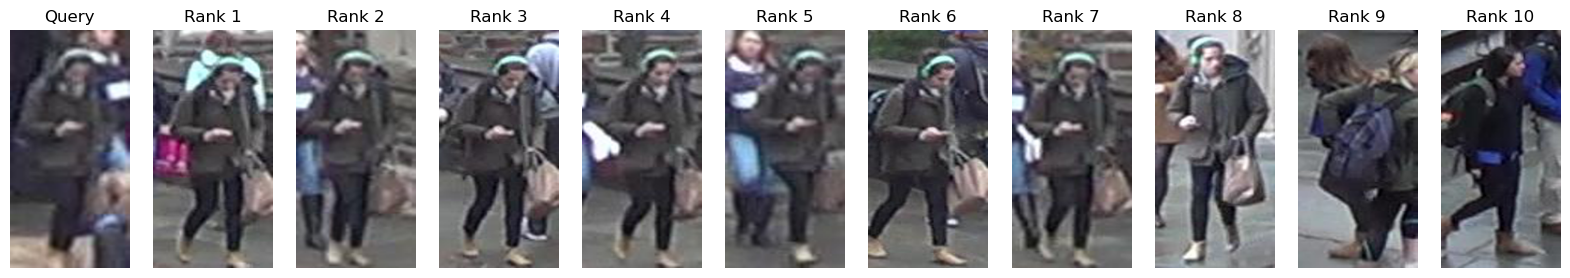

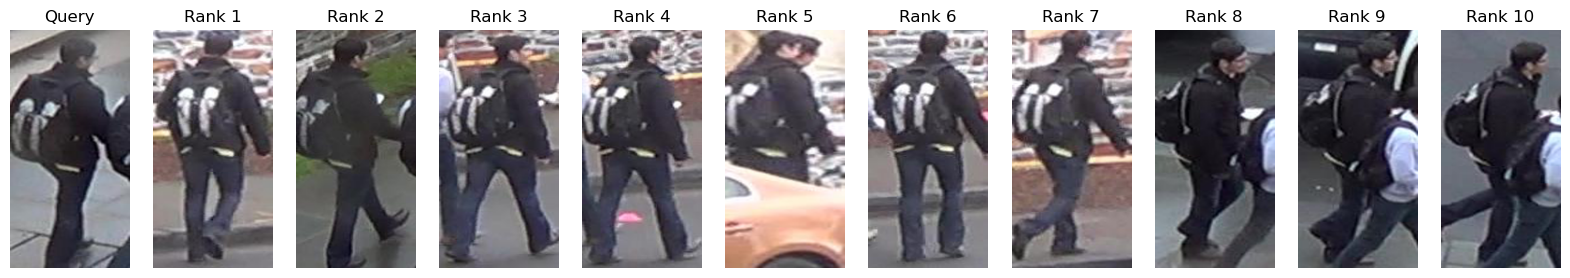

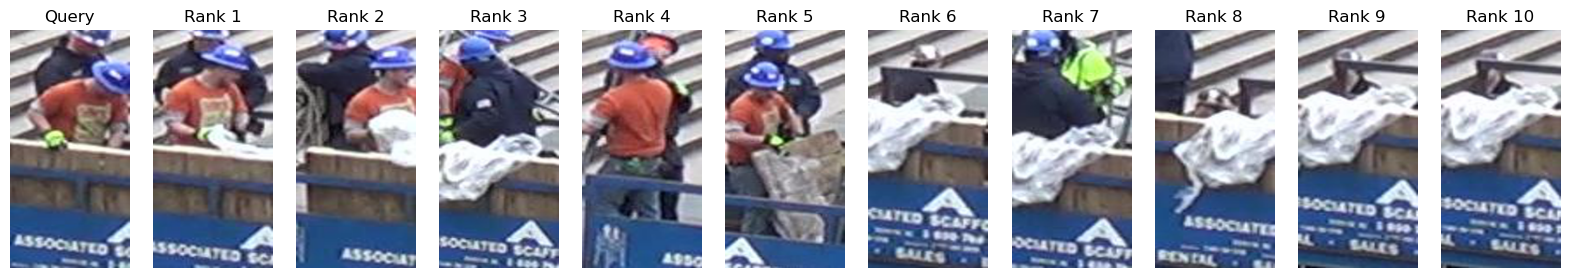

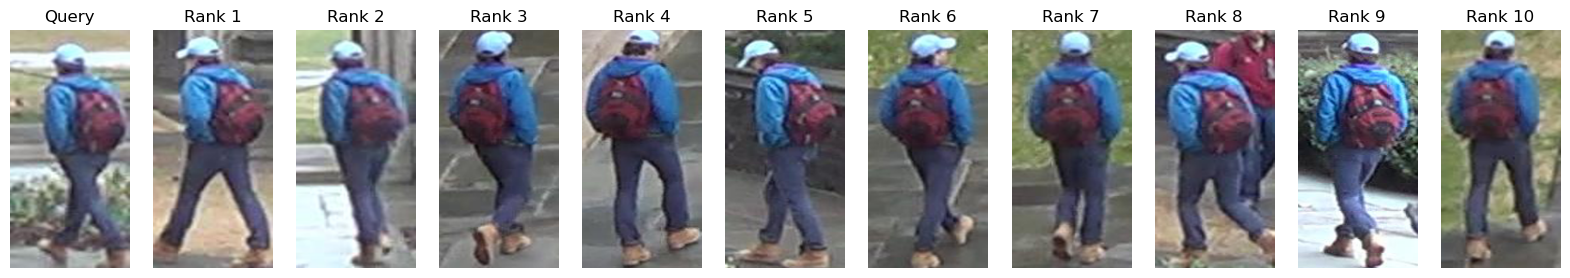

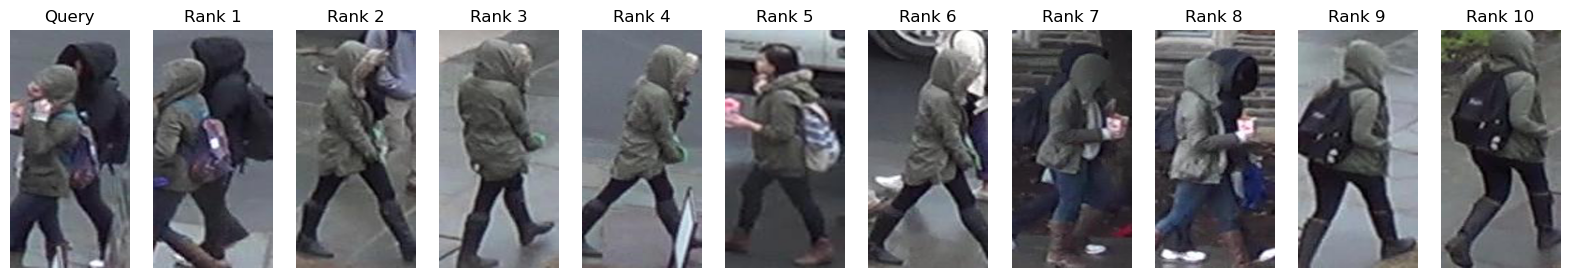

In [28]:
from PIL import Image
import os

def show_top_ranked_images(show_range, query_loader, gallery_loader, ranked_indices, query_labels, topk=10, save_dir='ranked_images', image_size=(256, 128)):
    query_images = [img_path for img_path, _, _ in query_loader]
    gallery_images = [img_path for img_path, _, _ in gallery_loader]

    
    for i, query_img_path in enumerate(query_images):
        if i in show_range:
            query_img_path = query_images[i]
            query_person_id = query_labels[i]
            person_dir = os.path.join(save_dir, str(query_person_id))
            if not os.path.exists(person_dir):
                os.makedirs(person_dir)
            
            # Save the query image
            query_img = Image.open(query_img_path).resize(image_size)
            query_img.save(os.path.join(person_dir, 'query.jpg'))
            
            # Save the topk ranked gallery images
            for j in range(topk):
                gallery_img_path = gallery_images[ranked_indices[i][j]]
                gallery_img = Image.open(gallery_img_path).resize(image_size)
                gallery_img.save(os.path.join(person_dir, f'rank_{j+1}.jpg'))
            
            # Save a plot of the query and top ranked images
            fig, axes = plt.subplots(1, topk + 1, figsize=(20, 5))
            axes[0].imshow(query_img)
            axes[0].set_title('Query')
            axes[0].axis('off')
            for j in range(topk):
                gallery_img_path = gallery_images[ranked_indices[i][j]]
                gallery_img = Image.open(gallery_img_path).resize(image_size)
                axes[j + 1].imshow(gallery_img)
                axes[j + 1].set_title(f'Rank {j + 1}')
                axes[j + 1].axis('off')
            plt.savefig(os.path.join(person_dir, 'top_ranked_images.png'))
            plt.show()
            plt.close()
        elif show_range==None:  
            query_img_path = query_images[i]
            query_person_id = query_labels[i]
            person_dir = os.path.join(save_dir, str(query_person_id))
            if not os.path.exists(person_dir):
                os.makedirs(person_dir)
            
            # Save the query image
            query_img = Image.open(query_img_path).resize(image_size)
            query_img.save(os.path.join(person_dir, 'query.jpg'))
            
            # Save the topk ranked gallery images
            for j in range(topk):
                gallery_img_path = gallery_images[ranked_indices[i][j]]
                gallery_img = Image.open(gallery_img_path).resize(image_size)
                gallery_img.save(os.path.join(person_dir, f'rank_{j+1}.jpg'))
            
            # Save a plot of the query and top ranked images
            fig, axes = plt.subplots(1, topk + 1, figsize=(20, 5))
            axes[0].imshow(query_img)
            axes[0].set_title('Query')
            axes[0].axis('off')
            for j in range(topk):
                gallery_img_path = gallery_images[ranked_indices[i][j]]
                gallery_img = Image.open(gallery_img_path).resize(image_size)
                axes[j + 1].imshow(gallery_img)
                axes[j + 1].set_title(f'Rank {j + 1}')
                axes[j + 1].axis('off')
            plt.savefig(os.path.join(person_dir, 'top_ranked_images.png'))
            #plt.show()
            plt.close()
        else:
            continue
show_top_ranked_images(range(100,105), dataset_target.query, dataset_target.gallery, ranked_indices, query_ids, topk=10, save_dir='/home/jun/UDAStrongBaseline/Test_rank10', image_size=(128, 256))